In [1]:
import os

# Check if the notebook is running on Colab
if 'COLAB_GPU' in os.environ:
    # This block will run only in Google Colab
    IN_COLAB = True
    print("Running on Google Colab. Cloning the repository.")
    !git clone https://github.com/pedro15sousa/energy-based-models-compression.git
    %cd energy-based-models-compression/notebooks
else: 
    # This block will run if not in Google Colab
    IN_COLAB = False
    print("Not running on Google Colab. Assuming local environment.")

Not running on Google Colab. Assuming local environment.


In [2]:
import sys
sys.path.append('..')  # This adds the parent directory (main_folder) to the Python path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.utils.data as data
import torch.nn.utils.prune as prune

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning
    import pytorch_lightning as pl
# Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# Pytorch Summary
try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install --quiet torchsummary
    from torchsummary import summary

import numpy as np
import pandas as pd
import json
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

from metrics.classifier import VGG
from metrics.scores import frechet_inception_distance, inception_score
from EBM import DeepEnergyModel
from energy_funcs.cnn import CNNModel
from sampler import Sampler
from callbacks import InceptionScoreCallback, \
    FIDCallback, SamplerCallback, OutlierCallback, \
    GenerateImagesCallback

import shutil
if IN_COLAB:
    from google.colab import files

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models"

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

pl.seed_everything(43)

/var/folders/pl/gjvtfzbj4691nr_0pszjdspw0000gn/T/ipykernel_50170/300413872.py:36: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 43


Device: cpu
Device:  cpu


43

In [4]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True,  drop_last=True,  num_workers=2, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=128, shuffle=False, drop_last=False, num_workers=2)

In [5]:
if os.path.exists('../saved_models/mnist-classifier-1 (1).pth'):
    # Load the best model
    mnist_classifier = VGG()

    if device == 'cuda':
        mnist_classifier.load_state_dict(torch.load('../saved_models/mnist-classifier-1 (1).pth'))
    else:
        mnist_classifier.load_state_dict(torch.load('../saved_models/mnist-classifier-1 (1).pth', map_location=torch.device('cpu')))

    mnist_classifier.to(device)
    print("Model already exists and loaded.")
    summary(mnist_classifier, input_size=(1, 28, 28))
else:
    print("Classifier not found in saved_models. Please run the classifier notebook first.")

Model already exists and loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
              ReLU-2          [-1, 128, 28, 28]               0
            Conv2d-3          [-1, 128, 28, 28]         147,584
              ReLU-4          [-1, 128, 28, 28]               0
            Conv2d-5          [-1, 128, 28, 28]         147,584
              ReLU-6          [-1, 128, 28, 28]               0
         MaxPool2d-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 14, 14]         295,168
              ReLU-9          [-1, 256, 14, 14]               0
           Conv2d-10          [-1, 256, 14, 14]         590,080
             ReLU-11          [-1, 256, 14, 14]               0
           Conv2d-12          [-1, 256, 14, 14]         590,080
             ReLU-13          [-1, 256, 14, 14]               0
      

In [6]:
@torch.no_grad()
def calculate_fid(real_imgs, fake_imgs, mnist_classifier):
    # Function to calculate the FID score

    def extract_features(images, model):
        # Function to extract features from images using the provided model
        model.eval()
        # with torch.no_grad():
        features = model.get_activations(images)
        return features.cpu().numpy()

    # Extract features from real and fake images
    real_features = extract_features(real_imgs, mnist_classifier)
    fake_features = extract_features(fake_imgs, mnist_classifier)

    fid_score = frechet_inception_distance(real_features, fake_features)
    
    return fid_score

In [7]:
@torch.no_grad()
def calculate_inception(fake_imgs, mnist_classifier):
    # Function to calculate the IS score
    mnist_classifier.eval()
    # with torch.no_grad():
    log_p_yx = mnist_classifier(fake_imgs)
    p_yx = torch.exp(log_p_yx).cpu().numpy()
    score = inception_score(p_yx)

    return score

In [8]:
@torch.no_grad()
def calculate_ood_detection(model, rand=True):
    # Function to calculate out-of-distribution detection score
    # rand=True: random samples 
    # rand=False: samples from the training set
    model.eval()
    if rand:
        rand_imgs = torch.rand((128,) + model.hparams.img_shape).to(model.device)
        rand_imgs = rand_imgs * 2 - 1.0
        rand_out = model.cnn(rand_imgs).mean()
        print(f"Average score for random images: {rand_out.item():4.2f}")
        return rand_out.item()

    else:
        train_imgs,_ = next(iter(train_loader))
        train_imgs = train_imgs.to(model.device)
        train_out = model.cnn(train_imgs).mean()
        print(f"Average score for training images: {train_out.item():4.2f}")
        return train_out.item()

In [9]:
@torch.no_grad()
def compare_images(img1, img2, model):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    score1, score2 = model.cnn(imgs).cpu().chunk(2, dim=0)
    score1, score2 = score1.mean(), score2.mean()
    # grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    img1 = (img1 + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    img2 = (img2 + 1) / 2
    grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,4))
    plt.imshow(grid)
    plt.xticks([(img1.shape[2]+2)*(0.5+j) for j in range(2)],
               labels=["Original image", "Transformed image"])
    plt.yticks([])
    plt.show()
    print(f"Score original image: {score1.item():4.2f}")
    print(f"Score transformed image: {score2.item():4.2f}")
    return [score1.item(), score2.item()]

In [10]:
def transform_image(transformation, model):
    test_imgs, _ = next(iter(test_loader))
    exmp_img = test_imgs[0].to(model.device)
    transformed_img = None
    if transformation == "noise":
        transformed_img = exmp_img + torch.randn_like(exmp_img) * 0.3
        transformed_img.clamp_(min=-1.0, max=1.0)
    elif transformation == "flip":
        transformed_img = exmp_img.flip(dims=(1,2))
    elif transformation == "tiny":
        transformed_img = torch.zeros_like(exmp_img)-1
        transformed_img[:,exmp_img.shape[1]//2:,exmp_img.shape[2]//2:] = exmp_img[:,::2,::2]
    
    return exmp_img, transformed_img

In [11]:
def get_images(model, train=False):
    data_loader = train_loader if train else test_loader
    real_imgs = None
    for imgs, _ in data_loader:
        real_imgs = imgs.cpu() # Move to CPU 
        break  # Only one batch is needed
    
    batch_size = real_imgs.shape[0]
    callback = GenerateImagesCallback(batch_size=batch_size, vis_steps=8, num_steps=1)
    fake_imgs = callback.generate_imgs(model)
    fake_imgs = fake_imgs.squeeze(0).cpu()

    return real_imgs, fake_imgs

In [12]:

if IN_COLAB:
    pretrained_filename = os.path.join(DRIVE_PATH, "MNIST_resnet18.ckpt")
else:
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST_resnet18.ckpt")

model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
summary(model, input_size=(1, 28, 28))
# pl.seed_everything(43)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
             Swish-2           [-1, 64, 14, 14]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4             [-1, 64, 7, 7]          36,928
             Swish-5             [-1, 64, 7, 7]               0
            Conv2d-6             [-1, 64, 7, 7]          36,928
             Swish-7             [-1, 64, 7, 7]               0
BasicResidualBlock-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          36,928
            Swish-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          36,928
            Swish-12             [-1, 64, 7, 7]               0
BasicResidualBlock-13             [-1, 64, 7, 7]               0
           Conv2d-14            [-1, 1

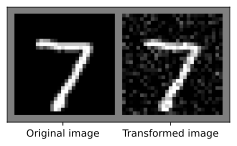

Score original image: 0.01
Score transformed image: 0.00


[0.006521356292068958, 0.0030122455209493637]

In [13]:
images = transform_image("noise", model)
compare_images(*images, model)

## Students

In [14]:
class DistilledDeepEnergyModel(DeepEnergyModel):
    def __init__(self, img_shape, batch_size, soft_loss_weight, hard_loss_weight, 
                temperature=2.0, f=CNNModel, **f_args):
        super().__init__(img_shape=img_shape, batch_size=batch_size, f=f, **f_args)
        self.teacher_energy = nn.Linear(10, 1).to(device)
        self.soft_loss_weight = soft_loss_weight
        self.hard_loss_weight = hard_loss_weight
        self.temperature = temperature
        self.cnn = f(**f_args).to(device)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)

    # def set_teacher_model(self, teacher_model):
    #     self.teacher_model = teacher_model
    #     self.teacher_model.eval()

    def get_mse_loss(self, student_output, teacher_output):
        """
        Calculate the MSE loss as the KL divergence between the soft targets from the teacher
        and the predictions of the student. The temperature T is used to soften the probability distributions.
        """
        loss = F.mse_loss(student_output, teacher_output)
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = super().training_step(batch, batch_idx)

        real_imgs, _ = batch
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)
        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)

        student_energy = self.cnn(inp_imgs)
        with torch.no_grad():
            teacher_energy = self.teacher_energy(teacher_model(inp_imgs)).squeeze()

        # Calculate mse loss and add it to the original loss
        mse_loss = self.get_mse_loss(student_energy, teacher_energy)
        total_loss = self.hard_loss_weight*loss + self.soft_loss_weight*mse_loss

        # Logging
        self.log('distillation_loss', mse_loss)
        self.log('total_loss', total_loss)

        return total_loss

    def validation_step(self, batch, batch_idx):
        loss = super().training_step(batch, batch_idx)

        real_imgs, _ = batch
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)
        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)

        student_energy = self.cnn(inp_imgs)
        with torch.no_grad():
            teacher_energy = self.teacher_energy(teacher_model(inp_imgs))

        # Calculate mse loss and add it to the original loss
        mse_loss = self.get_mse_loss(student_energy, teacher_energy)
        total_loss = self.hard_loss_weight*loss + self.soft_loss_weight*mse_loss

        self.log('val_distillation_loss', mse_loss)
        self.log('val_total_loss', total_loss)
        return mse_loss

In [30]:
student_1_filename = os.path.join(CHECKPOINT_PATH, "MNIST/student/MNIST_resnet_student_1.ckpt")
student_1_model = DistilledDeepEnergyModel.load_from_checkpoint(student_1_filename)
summary(student_1_model, input_size=(1, 28, 28))
print(student_1_model.cnn)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             416
             Swish-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
             Swish-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
             Swish-6             [-1, 64, 4, 4]               0
            Conv2d-7             [-1, 64, 2, 2]          36,928
             Swish-8             [-1, 64, 2, 2]               0
           Flatten-9                  [-1, 256]               0
           Linear-10                   [-1, 64]          16,448
            Swish-11                   [-1, 64]               0
           Linear-12                    [-1, 1]              65
         CNNModel-13                       [-1]               0
Total params: 76,993
Trainable params: 

In [18]:
real_imgs, fake_imgs = get_images(student_1_model, train=False)
fid_score_1 = calculate_fid(real_imgs, fake_imgs, mnist_classifier)
is_score_1 = calculate_inception(fake_imgs, mnist_classifier)
print("FID Score: ", fid_score_1)
print("IS Score: ", is_score_1)

FID Score:  5108.727863677883
IS Score:  1.2486746


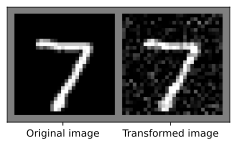

Score original image: 0.01
Score transformed image: -0.12


[0.013212740421295166, -0.12282361090183258]

In [19]:
images = transform_image("noise", student_1_model)
compare_images(*images, student_1_model)

Seed set to 43


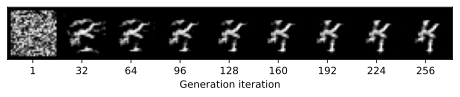

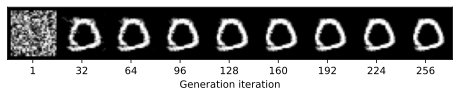

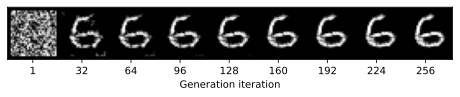

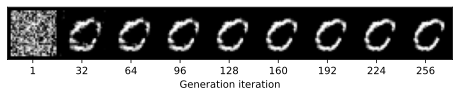

In [20]:
callback = GenerateImagesCallback(batch_size=4, vis_steps=8, num_steps=256)
imgs_per_step = callback.generate_imgs(student_1_model)
imgs_per_step = imgs_per_step.cpu()
pl.seed_everything(43)

for i in range(imgs_per_step.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
    imgs_to_plot = torch.cat([imgs_per_step[0:1,i],imgs_to_plot], dim=0)

    # Normalize the images
    imgs_to_plot = (imgs_to_plot + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True)
                
    # grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps+1)],
               labels=[1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()

In [31]:
student_2_filename = os.path.join(CHECKPOINT_PATH, "MNIST/student/MNIST_resnet_student_2.ckpt")
student_2_model = DistilledDeepEnergyModel.load_from_checkpoint(student_2_filename)
summary(student_2_model, input_size=(1, 28, 28))
print(student_2_model.cnn)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
             Swish-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,304
             Swish-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           2,304
             Swish-6           [-1, 16, 28, 28]               0
       ResNetBlock-7           [-1, 16, 28, 28]               0
            Conv2d-8           [-1, 16, 28, 28]           2,304
             Swish-9           [-1, 16, 28, 28]               0
           Conv2d-10           [-1, 16, 28, 28]           2,304
            Swish-11           [-1, 16, 28, 28]               0
      ResNetBlock-12           [-1, 16, 28, 28]               0
           Conv2d-13           [-1, 16, 28, 28]           2,304
            Swish-14           [-1, 16,

In [24]:
real_imgs, fake_imgs = get_images(student_2_model, train=False)
fid_score_2 = calculate_fid(real_imgs, fake_imgs, mnist_classifier)
is_score_2 = calculate_inception(fake_imgs, mnist_classifier)
print("FID Score: ", fid_score_2)
print("IS Score: ", is_score_2)

FID Score:  5647.452194109706
IS Score:  1.1508757


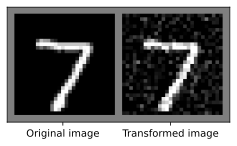

Score original image: 0.01
Score transformed image: 0.00


[0.007880382239818573, 0.00375624792650342]

In [25]:
images = transform_image("noise", student_2_model)
compare_images(*images, student_2_model)

Seed set to 43


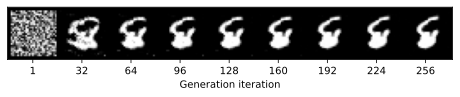

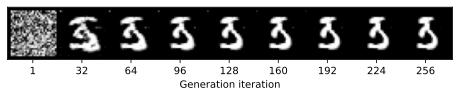

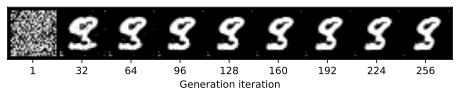

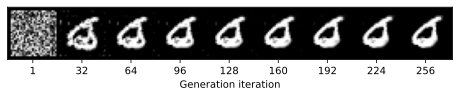

In [32]:
callback = GenerateImagesCallback(batch_size=4, vis_steps=8, num_steps=256)
imgs_per_step = callback.generate_imgs(student_2_model)
imgs_per_step = imgs_per_step.cpu()
pl.seed_everything(43)

for i in range(imgs_per_step.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
    imgs_to_plot = torch.cat([imgs_per_step[0:1,i],imgs_to_plot], dim=0)

    # Normalize the images
    imgs_to_plot = (imgs_to_plot + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True)
                
    # grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps+1)],
               labels=[1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()

In [29]:
with torch.no_grad():
    rand_imgs = torch.rand((128,) + model.hparams.img_shape).to(student_2_model.device)
    rand_imgs = rand_imgs * 2 - 1.0
    rand_out = student_2_model.cnn(rand_imgs).mean()
    print(f"Average score for random images: {rand_out.item():4.2f}")

Average score for random images: -1.62
